<a href="https://colab.research.google.com/github/SaraJawad0/Threat-Detection-System--UNSW_NB15-Dataset/blob/main/UNSW_NB15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import the necessary libraries**

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import zscore
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

# **Concat Dataset Files**

First thing first, we need to concat the .CSV files of the dataset togather so we can hendle them all togather and then add the columns names from the features CSV file

In [33]:
# List of file paths
files = [
    "/content/UNSW-NB15_1.csv",
    "/content/UNSW-NB15_2.csv",
    "/content/UNSW-NB15_3.csv",
    "/content/UNSW-NB15_4.csv"
]

# Creating an empty dict, where I will save all parameters required for test data transformation
#saved_dict = {}

# Load and concatenate all files with header=None (no column names in the files)
df_list = [pd.read_csv(file, header=None, low_memory=False) for file in files]
all_data = pd.concat(df_list).reset_index(drop=True)

# This csv file contains names of all the features
df_col = pd.read_csv('./NUSW-NB15_features.csv', encoding='ISO-8859-1')

# Clean column names (lowercase, strip spaces)
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

# Assign column names to the combined dataset
all_data.columns = df_col['Name']

# Preview the result
print("Combined dataset shape:", all_data.shape)
print(all_data.head())

Combined dataset shape: (2540047, 49)
Name       srcip  sport          dstip dsport proto state       dur  sbytes  \
0     59.166.0.0   1390  149.171.126.6     53   udp   CON  0.001055     132   
1     59.166.0.0  33661  149.171.126.9   1024   udp   CON  0.036133     528   
2     59.166.0.6   1464  149.171.126.7     53   udp   CON  0.001119     146   
3     59.166.0.5   3593  149.171.126.5     53   udp   CON  0.001209     132   
4     59.166.0.3  49664  149.171.126.0     53   udp   CON  0.001169     146   

Name  dbytes  sttl  ...  ct_ftp_cmd  ct_srv_src  ct_srv_dst ct_dst_ltm  \
0        164    31  ...           0           3           7          1   
1        304    31  ...           0           2           4          2   
2        178    31  ...           0          12           8          1   
3        164    31  ...           0           6           9          1   
4        178    31  ...           0           7           9          1   

Name  ct_src_ltm  ct_src_dport_ltm  ct_dst

# **Save Preprocessed Dataset Sample**

In [34]:
# Select the first 1000 rows + the columns row
sampled_preprocessed_data = all_data.head(1000)
# Save to CSV
sampled_preprocessed_data.to_csv('sampled_1000_rows.csv', index=False)

# **Explore the Dataset**

Missing values per column:
Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat          

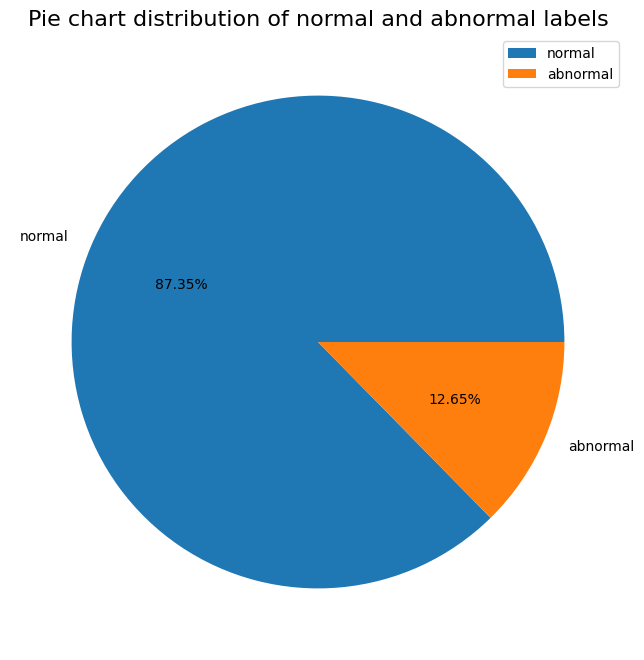

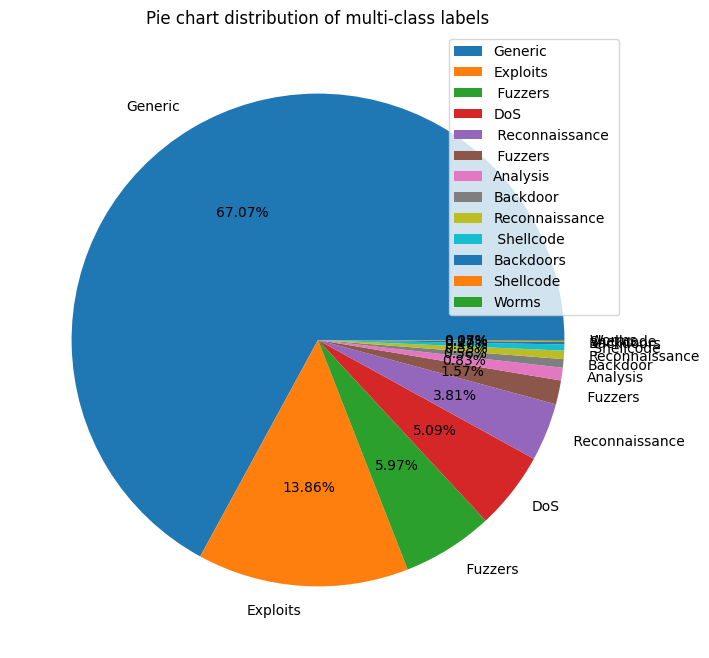

In [35]:
# show the missing values in the dataset
print("Missing values per column:")
print(all_data.isnull().sum())

# show normal (0) vs attack (1) traffic before in pre-processing
label_counts = all_data['label'].value_counts()

# Display the result
print("Label counts (Normal vs Attack):")
print(label_counts)


plt.figure(figsize=(8,8))
plt.pie(all_data.label.value_counts(),labels=['normal','abnormal'],autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels",fontsize=16)
plt.legend()
plt.show()

# Get the value counts for 'attack_cat'
attack_cat_counts = all_data.attack_cat.value_counts()

# Plot the pie chart
plt.figure(figsize=(8,8))
plt.pie(attack_cat_counts, labels=attack_cat_counts.index, autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend(loc='best')
plt.show()

# **Dataset Balancing**

We can notice that the dataset is imbalanced ( Normal traffic (0) > Attack traffic (1). Therefore, we need to balance the dataset.

In [36]:
# Separate majority and minority classes
majority_class = all_data[all_data['label'] == 0]  # Majority class (0)
minority_class = all_data[all_data['label'] == 1]  # Minority class (1)

# Check current value counts
print("Before resampling:")
print(all_data['label'].value_counts())

# Define the target size for each class
target_size = 500000

# Downsample majority class if it's larger than the target size
if len(majority_class) > target_size:
    majority_class_downsampled = resample(majority_class,
                                          replace=False,  # Without replacement
                                          n_samples=target_size,  # Reduce to target size
                                          random_state=42)
else:
    majority_class_downsampled = majority_class

# Upsample minority class if it's smaller than the target size
if len(minority_class) < target_size:
    minority_class_upsampled = resample(minority_class,
                                        replace=True,  # With replacement
                                        n_samples=target_size,  # Increase to target size
                                        random_state=42)
else:
    minority_class_upsampled = minority_class

# Combine the downsampled majority class and upsampled minority class
all_data_balanced = pd.concat([majority_class_downsampled, minority_class_upsampled])

# Shuffle the dataset to mix the classes randomly
all_data_balanced = all_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new value counts to confirm balancing
print("\nAfter resampling:")
print(all_data_balanced['label'].value_counts())

# Assuming all_data_balanced is your balanced dataset
all_data = all_data_balanced

# Now you can continue to use all_data as usual in your code
# Delete the balanced dataset reference (if not needed anymore)
del all_data_balanced

# Run garbage collection to free up memory
gc.collect()

Before resampling:
label
0    2218764
1     321283
Name: count, dtype: int64

After resampling:
label
1    500000
0    500000
Name: count, dtype: int64


30602

# **Filling Missing Values**

In [37]:
## before removing null values in the attack_cat column
print("before removing null values in the attack_cat column")
print(all_data['attack_cat'].value_counts())
# for the attack_cat column, there is a lot of null values because normal traffic doesn't have a value on that field. Therefore fill it:
all_data.loc[all_data['label'] == 0, 'attack_cat'] = all_data.loc[all_data['label'] == 0, 'attack_cat'].fillna('normal')
## after removing null values in the attack_cat column
print("after removing null values in the attack_cat column")
print(all_data['attack_cat'].value_counts())

## for the ct_flw_http_mthd column, fill it with 0
all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)
print(all_data['ct_flw_http_mthd'].value_counts())

## there are null values in is_ftp_login so let's view it
print("view values in the is_ftp_columns")
print(all_data['is_ftp_login'].value_counts())
# this field contains values that can be integer (it should be a binary field but we will handle this later) so lets transform the value type and full the null values with 0
all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0)).astype(int)
## after removing null values in the is_ftp_login column
print("view values in the is_ftp_columns after removing the null values")
print(all_data['is_ftp_login'].value_counts())

##ensure no null value exists
print("Missing values per column:")
print(all_data.isnull().sum())

before removing null values in the attack_cat column
attack_cat
Generic             335312
Exploits             69146
 Fuzzers             30170
DoS                  25380
 Reconnaissance      19118
 Fuzzers              7850
Analysis              4055
Backdoor              2768
Reconnaissance        2706
 Shellcode            2043
Backdoors              845
Shellcode              339
Worms                  268
Name: count, dtype: int64
after removing null values in the attack_cat column
attack_cat
normal              500000
Generic             335312
Exploits             69146
 Fuzzers             30170
DoS                  25380
 Reconnaissance      19118
 Fuzzers              7850
Analysis              4055
Backdoor              2768
Reconnaissance        2706
 Shellcode            2043
Backdoors              845
Shellcode              339
Worms                  268
Name: count, dtype: int64
ct_flw_http_mthd
0.0     930747
1.0      64164
4.0       2332
6.0       1817
2.0        235


# **Cleaning and Adjusting the Data to be Suitable to Handle**

With this dataset, there are categorial features, numerical features, and binary features that were specified in the features CSV file and in the research paper. However, we can notice that some features in the dataset are not correctly categorized, and the aim of this step is to correct these issues.

In [38]:
#view the categorial features
print(all_data.select_dtypes(exclude=np.number).columns)

# based in the research paper, it is clear that ct_ftp_cmd this is a numerical feature not a categorical.
#view the values exist in the ct_ftp_cmd column
print(all_data['ct_ftp_cmd'].unique())

# remove the space so we can transfom this column to numerical column
all_data['ct_ftp_cmd'] = all_data['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

# view the categorial features again after modification
print(all_data.select_dtypes(exclude=np.number).columns)

#now, view the numerical features
print(all_data.select_dtypes(include=np.number).columns)
# notice that 'is_sm_ips_ports' and 'is_ftp_login columns are considered numerical but based on the reasearch paper we know that these columns should be numerical but also bianry

# view if these two columns actually are numberic and bianry
# see if binary columns are really binary
for col in 'is_sm_ips_ports', 'is_ftp_login':
    print(all_data[col].value_counts())
    print()

#'is_sm_ips_ports' is binary. However, 'is_ftp login' is not
# replace values > 1 with 1 so it becoms binary
all_data['is_ftp_login'] = np.where(all_data['is_ftp_login']>1, 1, all_data['is_ftp_login'])
print(all_data['is_ftp_login'].value_counts())

#view the service column
print(all_data['service'].value_counts())
# we notice a '-', we need to replace that
# removing all the "-" and replacing those with "None"
all_data['service'] = all_data['service'].apply(lambda x:"None" if x=="-" else x)
print(print(all_data['service'].value_counts()))

# view the 'attack_cat' column
print(all_data['attack_cat'].value_counts())
#we notice 11 values but the research paper revealed that it contain 10 values not 11. This is becuase we have 'backdoor' and 'backdoors' even though they are the same attack
#replace backdoors to backdoor
all_data['attack_cat'] = all_data['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

#view
print(all_data.shape)

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'ct_ftp_cmd', 'attack_cat'],
      dtype='object', name='Name')
[' ' 0 3 '0' 1 '1' 5 '2' '4' 6 2 4 8]
Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'attack_cat'],
      dtype='object', name='Name')
Index(['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
       'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz',
       'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime',
       'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'],
      dtype='object', name='Name')
is_sm_ips_ports
0    999093
1       907
Name: count, dtype: int64

is_ftp_login
0    987649
1     12278
4        53
2        2

# **Categorial Features One Hot Encoding**

Our next step is going to be One-Hot encoding categorial features. However, I know that proto columns have a lot of values which will create more than 100 new columns when encoding, and therefore I am handling this issue below:

In [39]:
#view 'proto' column unique values
print(all_data['proto'].unique())
# view number of values for each unique value in 'proto'
print(all_data['proto'].value_counts())
#view the unique values that exist in 'proto' more than 1000 times (more frequent than the other protocols)
proto_counts = all_data['proto'].value_counts()
common_protos = proto_counts[proto_counts > 1000]
print(f"Number of proto values > 1000: {len(common_protos)}")
print(common_protos)
#for any unique value that has values lower than 1000 in the dataset, set it to 'proto_other'
min_freq = 1000
common_protos = all_data['proto'].value_counts()[lambda x: x > min_freq].index
all_data['proto'] = all_data['proto'].apply(lambda x: x if x in common_protos else 'proto_other')

['udp' 'tcp' 'emcon' 'ddp' 'sps' 'unas' 'argus' 'iatp' 'prm' 'ip' 'aris'
 'ipv6' 'ospf' 'ax.25' 'iso-ip' 'eigrp' 'mhrp' 'egp' 'br-sat-mon' 'rvd'
 'visa' 'arp' 'any' 'pim' 'hmp' 'sctp' 'iso-tp4' 'micp' 'idpr' 'tcf'
 'ipip' 'pup' 'mfe-nsp' 'rsvp' '3pc' 'aes-sp3-d' 'ddx' 'pgm' 'mtp' 'fc'
 'pvp' 'leaf-1' 'sccopmce' 'sat-mon' 'ipv6-route' 'zero' 'i-nlsp' 'irtp'
 'smp' 'idpr-cmtp' 'nvp' 'ipnip' 'qnx' 'cbt' 'snp' 'compaq-peer' 'encap'
 'secure-vmtp' 'ptp' 'xtp' 'wsn' 'pipe' 'scps' 'cphb' 'ipv6-opts' 'l2tp'
 'netblt' 'sat-expak' 'st2' 'ttp' 'sep' 'dcn' 'uti' 'leaf-2' 'il' 'xnet'
 'dgp' 'ipcv' 'swipe' 'cpnx' 'stp' 'tp++' 'wb-expak' 'cftp' 'mux' 'idrp'
 'a/n' 'bna' 'vrrp' 'merit-inp' 'wb-mon' 'gre' 'kryptolan' 'crudp'
 'etherip' 'vines' 'iplt' 'larp' 'pnni' 'srp' 'fire' 'gmtp' 'ipcomp'
 'sun-nd' 'trunk-1' 'crtp' 'mobile' 'ipx-n-ip' 'sdrp' 'sm' 'ippc'
 'ipv6-frag' 'trunk-2' 'chaos' 'nsfnet-igp' 'isis' 'tlsp' 'pri-enc'
 'bbn-rcc' 'xns-idp' 'skip' 'icmp' 'vmtp' 'igp' 'narp' 'rdp' 'ggp' 'ib'
 'ifmp'

In [40]:
# Identify and print categorical (non-numeric) columns
cat_col = all_data.select_dtypes(exclude=np.number).columns
print("Categorical columns to be encoded:")
print(cat_col)

# Define the categorical columns we want to one-hot encode
cols_to_encode = ['proto', 'service', 'state']

# Create a new DataFrame with just those columns
data_cat = all_data[cols_to_encode].copy()
# Check all values are True/False or 0/1 — then convert
if data_cat.isin([True, False]).all().all():
    data_cat = data_cat.astype(int)

# Apply one-hot encoding to the selected categorical columns
data_cat = pd.get_dummies(data_cat, columns=cols_to_encode)
for col in data_cat.columns:
    data_cat[col] = data_cat[col].astype(np.uint8)  # uses less memory than int64
print(data_cat.head())

# before adding the new columns
print("Dataset Before One Hot encoding")
print(all_data.shape)
# Concatenate the new one-hot-encoded DataFrame with the original dataset
all_data = pd.concat([all_data, data_cat], axis=1)

# after adding the new columns
print("Dataset After One Hot encoding")
print(all_data.shape)

# Drop the original categorical columns that have been one-hot encoded
all_data.drop(columns=cols_to_encode, inplace=True)

# after dropping the old categorial fields
print("Shape after selective one-hot encoding:", all_data.shape)
print(all_data.head())

Categorical columns to be encoded:
Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service',
       'attack_cat'],
      dtype='object', name='Name')
   proto_arp  proto_ospf  proto_proto_other  proto_sctp  proto_tcp  proto_udp  \
0          0           0                  0           0          0          1   
1          0           0                  0           0          1          0   
2          0           0                  0           0          0          1   
3          0           0                  0           0          0          1   
4          0           0                  0           0          1          0   

   proto_unas  service_None  service_dhcp  service_dns  ...  state_FIN  \
0           0             0             0            1  ...          0   
1           0             0             0            0  ...          1   
2           0             0             0            1  ...          0   
3           0             0             0           

# **Handle Non-Numeric Features**

In [41]:
# let us view the columns that are not numeric
non_numeric_columns = all_data.select_dtypes(exclude=np.number).columns
print(non_numeric_columns)


Index(['srcip', 'sport', 'dstip', 'dsport', 'attack_cat'], dtype='object')


In [42]:
# Dropping columns which are not useful for the classification
# attack_cat is for multiclass classification. Therefore, we won't use it
# all the other columns are address related and not present in data
all_data.drop(['srcip', 'sport', 'dstip', 'dsport', 'attack_cat'], axis=1, inplace=True)

# **Noise Reduction: Z-Score**

In [43]:
# Select numeric columns (excluding the label column)
numeric_cols = all_data.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'label']

# Calculate Z-scores for the numeric columns in all_data
z_scores = all_data[numeric_cols].apply(zscore)

# Define the Z-score threshold (commonly 3)
threshold = 3

# identify the data points that have a Z-score greater than 3 or less than -3, which are commonly considered outliers.
filtered_data = all_data[(np.abs(z_scores) < threshold).all(axis=1)]

# Display the shape of the original and filtered data
print(f"Original data shape: {all_data.shape}")
print(f"Filtered data shape (after removing outliers): {filtered_data.shape}")

# reassign the filtered data to all_data and delete filtered_data to save memory usage
all_data = filtered_data
del filtered_data

Original data shape: (1000000, 75)
Filtered data shape (after removing outliers): (659101, 75)


# **Normalization**

In [44]:
# Selecting numeric columns from the dataset
num_col = list(all_data.select_dtypes(include='number').columns)

# Remove irrelevant columns like'label' from the list of numeric columns
num_col.remove('label')  # Remove 'label' column (target column)

print(num_col)  # To see the list of numeric columns selected for normalization

# Using MinMaxScaler for normalizing the data between 0 and 1
minmax_scale = MinMaxScaler(feature_range=(0, 1))

# Function to apply MinMax normalization to the numeric columns
def normalization(df, col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)  # Convert to numpy array to apply scaler
        df[i] = minmax_scale.fit_transform(arr.reshape(len(arr), 1))  # Normalize and reshape to fit scaler
    return df

# Display data before normalization
print("Data before normalization:")
print(all_data.head())

# Apply the normalization function to the dataset
all_data = normalization(all_data.copy(), num_col)

#  Display data after normalization
print("Data after normalization:")
print(all_data.head())

['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'proto_arp', 'proto_ospf', 'proto_proto_other', 'proto_sctp', 'proto_tcp', 'proto_udp', 'proto_unas', 'service_None', 'service_dhcp', 'service_dns', 'service_ftp', 'service_ftp-data', 'service_http', 'service_irc', 'service_pop3', 'service_radius', 'service_smtp', 'service_snmp', 'service_ssh', 'service_ssl', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD', 'state_URH', 'state_URN']
Data before normalization:
        dur

# **Features Selection: PCA**

In [45]:
# Separate features and target variable
X = all_data.drop(columns=['label'])

# Apply PCA to reduce to 50 components
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# After fitting PCA
loadings = pd.DataFrame(pca.components_, columns=X.columns)
top_features_per_pc = loadings.abs().idxmax(axis=1)
print(top_features_per_pc)

pc_labels = [f'PC{i+1}_{top_features_per_pc[i]}' for i in range(50)]
X_pca_df = pd.DataFrame(X_pca, columns=pc_labels)

# Print the transformed data
print(X_pca_df.head())

# Check the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# Ensure both DataFrames have matching indices
X_pca_df.reset_index(drop=True, inplace=True)
label_col = all_data['label'].reset_index(drop=True)

# Add the label column back to the DataFrame
final_data = pd.concat([X_pca_df, label_col], axis=1)


# Print the shape of the final data
print(f"Final data shape: {final_data.shape}")

0            state_INT
1            state_CON
2                ltime
3                 sttl
4          service_dns
5                 dttl
6              dmeansz
7           ct_srv_src
8                sload
9                dtcpb
10               stcpb
11               sload
12    ct_dst_sport_ltm
13               dload
14             dmeansz
15             smeansz
16              synack
17          ct_src_ltm
18                djit
19           state_FIN
20        ct_state_ttl
21              ackdat
22          ct_srv_src
23      ct_dst_src_ltm
24    ct_src_dport_ltm
25              dbytes
26             dintpkt
27                dwin
28                 dur
29              sbytes
30               spkts
31             dintpkt
32                 dur
33         res_bdy_len
34               dpkts
35               sloss
36                swin
37               ltime
38           proto_tcp
39        is_ftp_login
40          ct_ftp_cmd
41        is_ftp_login
42    ct_flw_http_mthd
43         

In [46]:
#view the data before feature selection
print("Original number of features:", all_data.shape[1])
#view the data after feature selection
print("Number of selected features:", final_data.shape[1])

Original number of features: 75
Number of selected features: 51


# **Save the Processed Dataset**

In [47]:
# save the dataset after preprocessing tasks
final_data.to_csv('/content/Processed_data.csv')
# Select the first 1000 rows + the columns row
sampled_processed_data = final_data.head(1001)
# Save to CSV
sampled_processed_data.to_csv('processed_sampled_1000_rows.csv', index=False)

# **ML Models (Training & Testing)**

In [48]:
# Split your data into features (X) and target (y)
X = final_data.drop(columns=['label'])  # Features (excluding the target column)
y = final_data['label']  # Target (the 'label' column)

# Split the data into training(80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **1. Random Forest**



Random Forest Evaluation Report:
Accuracy: 0.9958
Precision: 0.9926
Recall: 0.9994
F1-Score: 0.9960


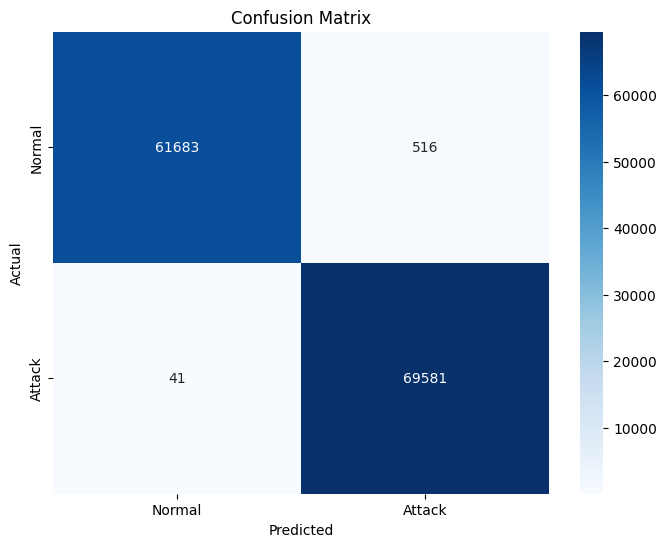

In [49]:
# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Evaluation Report:")

#compute accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf :.4f}")

# Compute Precision
precision_rf = precision_score(y_test, y_pred_rf)
print(f"Precision: {precision_rf :.4f}")

# Compute Recall
recall_rf = recall_score(y_test, y_pred_rf)
print(f"Recall: {recall_rf :.4f}")

# Compute F1-Score
f1_rf = f1_score(y_test, y_pred_rf)
print(f"F1-Score: {f1_rf :.4f}")


# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Display Confusion Matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=['Normal', 'Attack' ],
yticklabels=['Normal', 'Attack' ])
plt.xlabel('Predicted' )
plt.ylabel('Actual')
plt.title('Confusion Matrix' )
plt.show()

## **2. Logistic Regression**

Logistic Regression Evaluation Report:
Accuracy: 0.9947
Precision: 0.9915
Recall: 0.9985
F1-Score: 0.9950


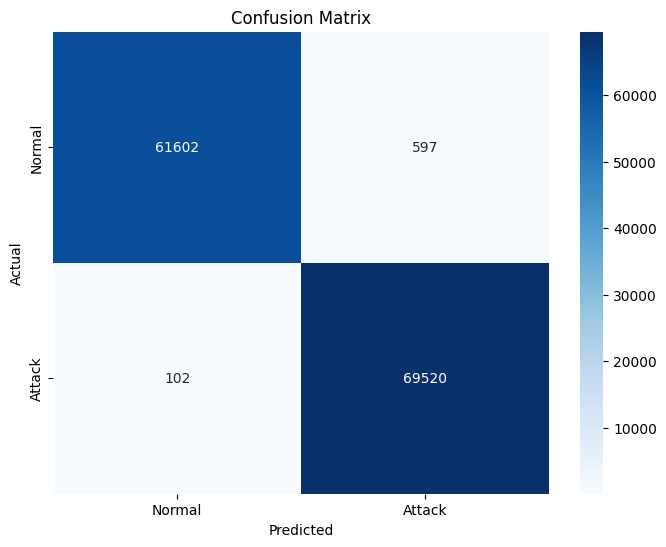

In [50]:
# Train a Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Evaluation Report:")

#compute accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr :.4f}")

# Compute Precision
precision_lr = precision_score(y_test, y_pred_lr)
print(f"Precision: {precision_lr :.4f}")

# Compute Recall
recall_lr = recall_score(y_test, y_pred_lr)
print(f"Recall: {recall_lr :.4f}")

# Compute F1-Score
f1_lr = f1_score(y_test, y_pred_lr)
print(f"F1-Score: {f1_lr :.4f}")


# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Display Confusion Matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=['Normal', 'Attack' ],
yticklabels=['Normal', 'Attack' ])
plt.xlabel('Predicted' )
plt.ylabel('Actual')
plt.title('Confusion Matrix' )
plt.show()

## **3. K-Nearest Neighbors**

K-Nearest Neighbors Evaluation Report:
Accuracy: 0.9951
Precision: 0.9923
Recall: 0.9984
F1-Score: 0.9954


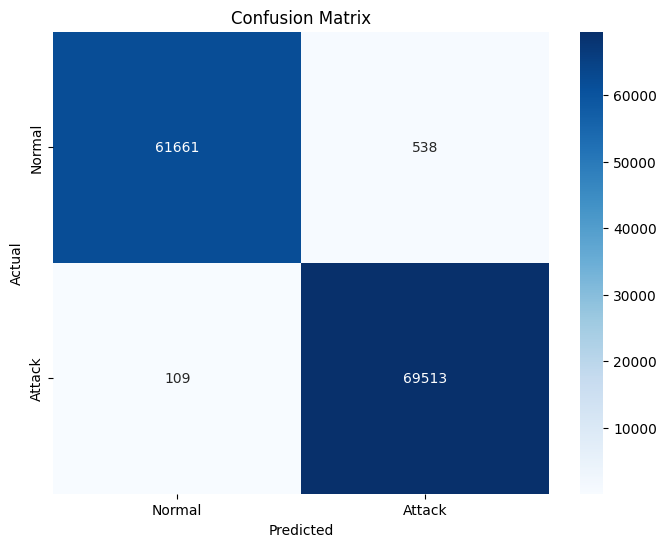

In [51]:
# Train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
print("K-Nearest Neighbors Evaluation Report:")

#compute accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn :.4f}")

# Compute Precision
precision_knn = precision_score(y_test, y_pred_knn)
print(f"Precision: {precision_knn :.4f}")

# Compute Recall
recall_knn = recall_score(y_test, y_pred_knn)
print(f"Recall: {recall_knn :.4f}")

# Compute F1-Score
f1_knn = f1_score(y_test, y_pred_knn)
print(f"F1-Score: {f1_knn :.4f}")


# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Display Confusion Matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=['Normal', 'Attack' ],
yticklabels=['Normal', 'Attack' ])
plt.xlabel('Predicted' )
plt.ylabel('Actual')
plt.title('Confusion Matrix' )
plt.show()

## **4. Decision Tree**

Decision Tree Evaluation Report:
Accuracy: 0.9953
Precision: 0.9945
Recall: 0.9965
F1-Score: 0.9955


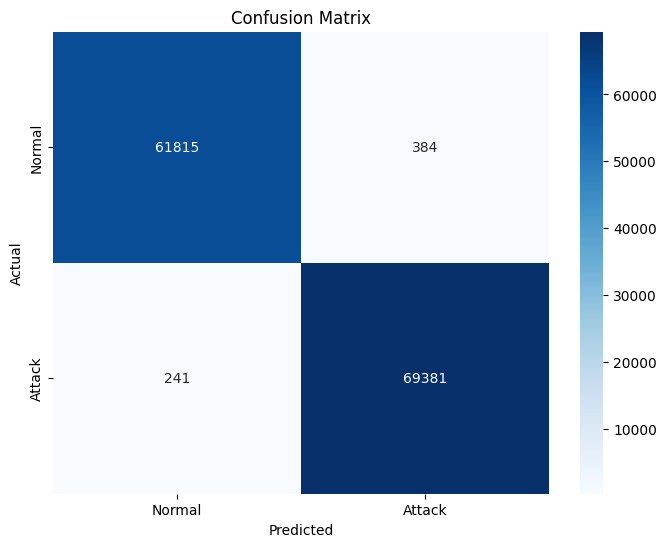

In [52]:
# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
print("Decision Tree Evaluation Report:")

#compute accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt :.4f}")

# Compute Precision
precision_dt = precision_score(y_test, y_pred_dt)
print(f"Precision: {precision_dt :.4f}")

# Compute Recall
recall_dt = recall_score(y_test, y_pred_dt)
print(f"Recall: {recall_dt :.4f}")

# Compute F1-Score
f1_dt = f1_score(y_test, y_pred_dt)
print(f"F1-Score: {f1_dt :.4f}")


# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Display Confusion Matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=['Normal', 'Attack' ],
yticklabels=['Normal', 'Attack' ])
plt.xlabel('Predicted' )
plt.ylabel('Actual')
plt.title('Confusion Matrix' )
plt.show()

## **5. Gradient Boosting**

Gradient Boosting Classifier Evaluation Report:
Accuracy: 0.9953
Precision: 0.9913
Recall: 0.9999
F1-Score: 0.9956


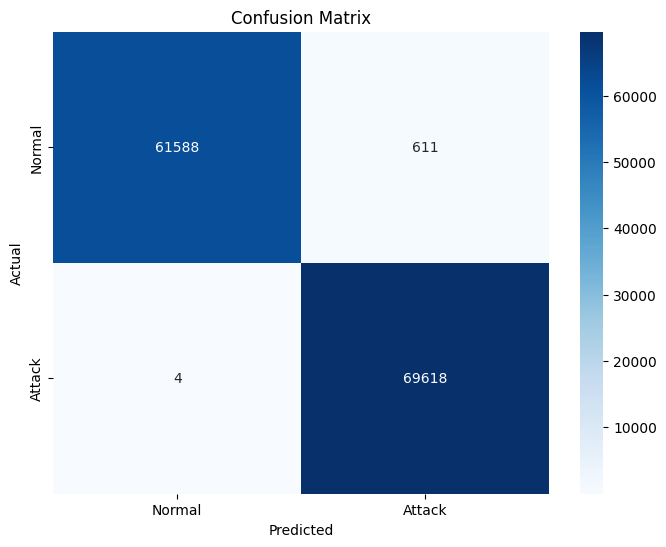

In [53]:
# Train a GradientBoostingClassifier model
GBC_model =  GradientBoostingClassifier(random_state=42)
GBC_model.fit(X_train, y_train)

# Make predictions
y_pred_GBC = GBC_model.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier Evaluation Report:")

#compute accuracy
accuracy_GBC = accuracy_score(y_test, y_pred_GBC)
print(f"Accuracy: {accuracy_GBC :.4f}")

# Compute Precision
precision_GBC = precision_score(y_test, y_pred_GBC)
print(f"Precision: {precision_GBC :.4f}")

# Compute Recall
recall_GBC = recall_score(y_test, y_pred_GBC)
print(f"Recall: {recall_GBC :.4f}")

# Compute F1-Score
f1_GBC = f1_score(y_test, y_pred_GBC)
print(f"F1-Score: {f1_GBC :.4f}")


# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred_GBC)

# Display Confusion Matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
xticklabels=['Normal', 'Attack' ],
yticklabels=['Normal', 'Attack' ])
plt.xlabel('Predicted' )
plt.ylabel('Actual')
plt.title('Confusion Matrix' )
plt.show()

# **Models Comparsion**

## **1. Accuracy Comparsion**

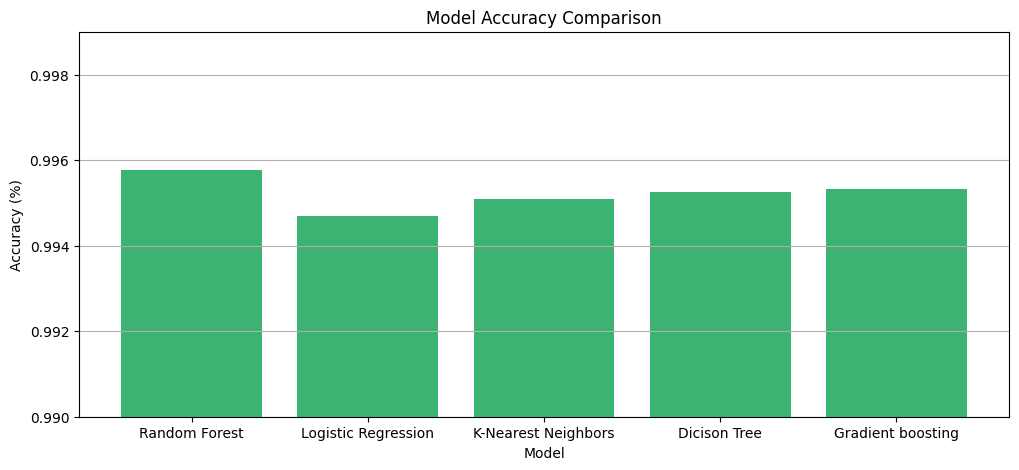

In [54]:
# Prepare data for plotting
models = ['Random Forest', 'Logistic Regression', 'K-Nearest Neighbors', 'Dicison Tree', 'Gradient boosting']

accuracies = [accuracy_rf, accuracy_lr, accuracy_knn, accuracy_dt, accuracy_GBC]

plt.figure(figsize=(12, 5))
plt.bar(models, accuracies, color='mediumseagreen')

# Focus the y-axis on the relevant range
plt.ylim(0.990, 0.999)

plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y')
plt.show()


## **2. Precision Comparsion**

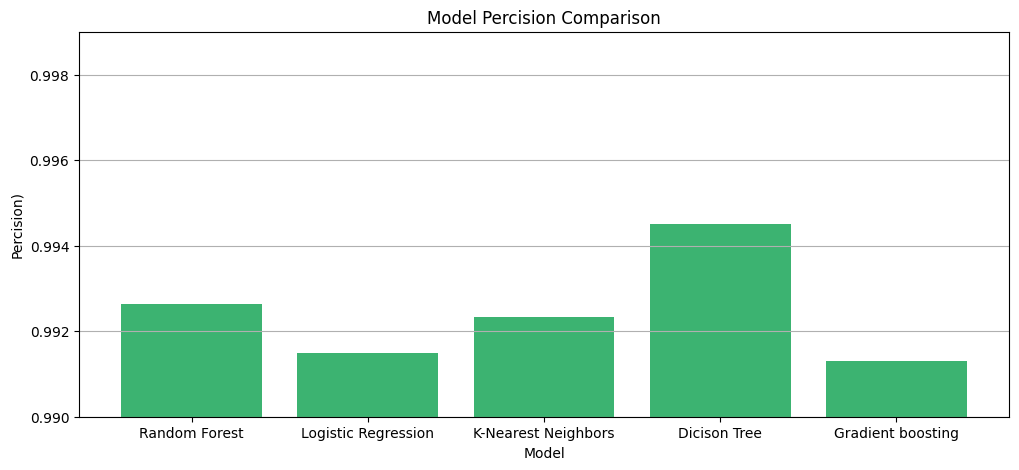

In [55]:
#prepare all the precision values I have calculated for the 5 models in an array.
precisions = [precision_rf, precision_lr, precision_knn, precision_dt, precision_GBC]

plt.figure(figsize=(12, 5))
plt.bar(models, precisions, color='mediumseagreen')

# Focus the y-axis on the relevant range
plt.ylim(0.990, 0.999)

plt.title('Model Percision Comparison')
plt.xlabel('Model')
plt.ylabel('Percision)')
plt.grid(axis='y')
plt.show()


## **3. Recall Comparsion**

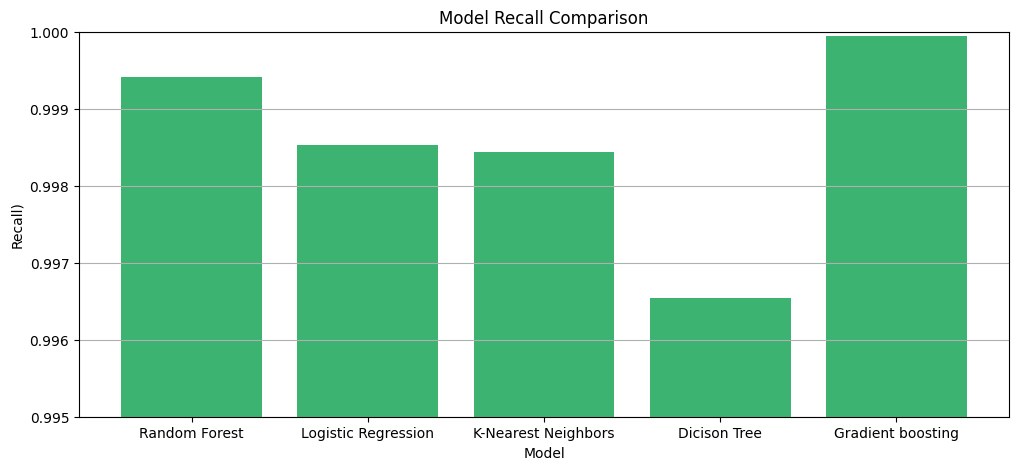

In [56]:
#prepare all the recall values I have calculated for the 5 models in an array.
recalls = [recall_rf, recall_lr, recall_knn, recall_dt, recall_GBC]

plt.figure(figsize=(12, 5))
plt.bar(models, recalls, color='mediumseagreen')

# Focus the y-axis on the relevant range
plt.ylim(0.995, 1.0)

plt.title('Model Recall Comparison')
plt.xlabel('Model')
plt.ylabel('Recall)')
plt.grid(axis='y')
plt.show()


## **4. F1-Score Comparsion**

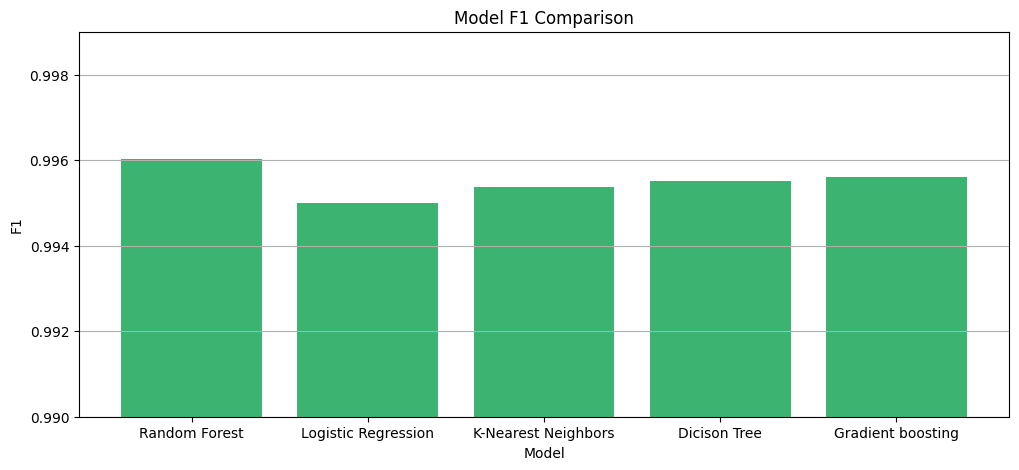

In [57]:
#prepare all the F1-score values I have calculated for the 5 models in an array.
f1 = [f1_rf, f1_lr, f1_knn, f1_dt, f1_GBC]

plt.figure(figsize=(12, 5))
plt.bar(models, f1, color='mediumseagreen')

# Focus the y-axis on the relevant range
plt.ylim(0.990, 0.999)

plt.title('Model F1 Comparison')
plt.xlabel('Model')
plt.ylabel('F1')
plt.grid(axis='y')
plt.show()
